# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sklearn.metrics
import dill as pickle
from catboost import EFstrType
import json
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
import optuna
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import numpy as np
from IPython.display import clear_output
import os

%load_ext jupyter_black
warnings.filterwarnings("ignore")

# Read data

In [2]:
# After reading the data, I reserve a small portion for inference.
df = pd.read_csv("loan_approval_dataset.csv")
df, test = train_test_split(df, stratify=df[" loan_status"], test_size=0.1)
# test.drop(" loan_status", axis=1, inplace=True)

df = df.reset_index(drop=True)
test = test.reset_index(drop=True)
df.shape, test.shape

((3842, 13), (427, 13))

# Define Config

In [3]:
class CFG:
    """
    Configuration class for model training.

    Attributes:
    - label (str): The target label column name.
    - id_cols (list): List of column names that are used as IDs and should be excluded from features.
    - FOLD_CNT (int): Number of folds for cross-validation.
    - SEED (int): Random seed for reproducibility.
    - DEVICE (str): Device to use for training ('CPU' or 'GPU').
    - ITERATION (int): Number of boosting iterations.
    - TUNE (bool): Whether to perform hyperparameter tuning.
    - EVAL_METRIC (str): Evaluation metric to use.
    - N_TRIAL (int): Number of hyperparameter tuning trials.
    - FEATURE_ELIMINATION (bool): Whether to perform feature elimination.
    - USE_CIBIL (bool): Whether to include the CIBIL SCORE feature, which might cause data leaks.
    """

    label = "loan_status"
    id_cols = ["loan_id"]
    FOLD_CNT = 5
    SEED = 42
    DEVICE = "CPU"
    ITERATION = 20000
    TUNE = True
    EVAL_METRIC = "f1_score"
    N_TRIAL = 2
    FEATURE_ELIMINATION = True
    USE_CIBIL = True  # CIBIL SCORE feature seems to cause a large amount of data leaks. However, I used this parameter as True because it was found in the original data and it increased the score very much. However, it is obvious that it leaked. If I had known the direct meaning of the colon, I would have evaluated the leakage situation and used it that way.

# Preprocessing

## Encoding

In [4]:
class EncoderEvaluator:
    """
    Class for evaluating different encoding methods for categorical columns.

    Attributes:
    - dataframe (DataFrame): The DataFrame containing the data.
    - target_column (str): The name of the target column.
    - categorical_columns (list): List of column names to encode.
    """

    def __init__(self, dataframe, target_column, categorical_columns):
        self.dataframe = dataframe
        self.target_column = target_column
        self.categorical_columns = categorical_columns
        self.X = dataframe.drop(columns=[target_column])
        self.y = dataframe[target_column]
        self.encoders = {
            #'onehot': OneHotEncoder(),
            "label": LabelEncoder(),
            "ordinal": ce.OrdinalEncoder(),
            "catboost": ce.CatBoostEncoder(),
            "target": ce.TargetEncoder(),
        }

    def evaluate_encoders(self):
        """
        Evaluates different encoding methods using cross-validation.

        Returns:
        - tuple: A tuple containing the best encoder name and the mean accuracy scores for each encoder.
        """

        results = {}
        for encoder_name, encoder in self.encoders.items():
            print(f"Evaluating with {encoder_name} encoder...")
            if encoder_name == "label":
                X_encoded = self.X.copy()
                for col in self.categorical_columns:
                    X_encoded[col] = LabelEncoder().fit_transform(self.X[col])
                scores = self._evaluate_model(X_encoded)
            else:
                preprocessor = ColumnTransformer(
                    transformers=[("encoder", encoder, self.categorical_columns)],
                    remainder="passthrough",
                )
                pipeline = Pipeline(
                    steps=[
                        ("preprocessor", preprocessor),
                        ("classifier", CatBoostClassifier(silent=True)),
                    ]
                )
                scores = cross_val_score(
                    pipeline, self.X, self.y, cv=5, scoring="accuracy"
                )

            results[encoder_name] = scores.mean()

        best_encoder = max(results, key=results.get)
        return best_encoder, results

    def _evaluate_model(self, X):
        """
        Evaluates a model using cross-validation.

        Args:
        - X (DataFrame): The input features.

        Returns:
        - array: An array of accuracy scores for each fold in cross-validation.
        """
        model = CatBoostClassifier(silent=True)
        scores = cross_val_score(model, X, self.y, cv=5, scoring="accuracy")
        return scores

### Extracted features:
1. **Debt-to-Income Ratio**:
   - **Feature**: `debt_to_income_ratio`
   - **Formula**: `loan_amount / income_annum`
   - **Rationale**: This ratio helps assess a borrower's ability to manage monthly payments and repay debts.

2. **Total Assets Value**:
   - **Feature**: `total_assets_value`
   - **Formula**: `residential_assets_value + commercial_assets_value + luxury_assets_value + bank_asset_value`
   - **Rationale**: Total assets provide an overall picture of the borrower's financial strength.

3. **Loan-to-Value Ratio (LTV)**:
   - **Feature**: `ltv_ratio`
   - **Formula**: `loan_amount / total_assets_value`
   - **Rationale**: LTV ratio indicates the risk level of the loan; lower LTV ratios are generally less risky.

4. **Income Stability**:
   - **Feature**: `income_stability`
   - **Formula**: 1 if `self_employed == 'No'`, else 0
   - **Rationale**: Employment status can indicate income stability, with non-self-employed individuals often having more stable incomes.

5. **Dependents to Income Ratio**:
   - **Feature**: `dependents_to_income_ratio`
   - **Formula**: `no_of_dependents / income_annum`
   - **Rationale**: This ratio helps assess the financial burden on the borrower.

6. **CIBIL Score Category**:
   - **Feature**: `cibil_score_category`
   - **Formula**: Categorize `cibil_score` into bins (e.g., 'Poor', 'Fair', 'Good', 'Excellent')
   - **Rationale**: CIBIL score categories can provide a qualitative assessment of creditworthiness.

7. **Loan Term in Years**:
   - **Feature**: `loan_term_years`
   - **Formula**: `loan_term / 12`
   - **Rationale**: Converting loan term into years can be more interpretable for analysis.

8. **High-Value Assets Indicator**:
   - **Feature**: `high_value_assets`
   - **Formula**: 1 if `total_assets_value` is above a certain threshold, else 0
   - **Rationale**: Indicates if the borrower holds high-value assets, which might be a positive factor for loan approval.


9.  **Equated Monthly Installment (EMI)**:
    - **Feature**: `emi`
    - **Formula**: Monthly payments calculated using Loan Amount and Term.
    - **Rationale**: Monthly loan payments indicate an individual's payment capacity.

10. **Income to Loan Amount Ratio**:
    - **Feature**: `income_to_loan_amount_ratio`
    - **Formula**: `income_annum / loan_amount`
    - **Rationale**: This ratio shows the adequacy of income relative to the loan amount.

11. **Individual Asset Ratio**:
    - **Feature**: `individual_asset_ratio`
    - **Formula**: `(residential_assets_value + luxury_assets_value) / total_assets_value`
    - **Rationale**: The ratio of individual assets to total assets shows the individual's financial status.

12. **Debt Service Ratio (DSR)**:
    - **Feature**: `debt_service_ratio`
    - **Formula**: `(loan_amount / loan_term) / income_annum`
    - **Rationale**: Debt service shows the amount of debt that can be covered by income.


In [5]:
class Preprocess:
    """
    Class for preprocessing data.

    Attributes:
    - df (DataFrame): The DataFrame containing the data.
    - inference (bool): Flag indicating whether the preprocessing is for inference.
    - encoder_path (str): Path to save/load encoder files.
    """

    def __init__(self, df, inference=False, encoder_path="encoder.pkl"):
        self.df = df.copy()
        self.categorical_features = ["education", "self_employed"]
        self.encoder_eval = EncoderEvaluator
        self.inference = inference
        self.encoder_path = encoder_path
        self.encoders = {
            #'onehot': OneHotEncoder(),
            "label": LabelEncoder(),
            "ordinal": ce.OrdinalEncoder(),
            "catboost": ce.CatBoostEncoder(),
            "target": ce.TargetEncoder(),
        }

    def fix_column_names(self):
        """
        Fix column names by stripping leading and trailing spaces.
        """

        self.df.columns = [col.strip() for col in self.df.columns]

    def fix_categorical_features(self):
        """
        Fix categorical feature values by stripping leading and trailing spaces.
        """
        for col in self.categorical_features:
            self.df[col] = self.df[col].str.strip()
        if "loan_status" in self.df.columns:
            self.df["loan_status"] = self.df["loan_status"].str.strip()

    def _object_to_category(self):
        cols = self.df.select_dtypes("object").columns.tolist()
        self.df[cols] = self.df[cols].astype("category")

    def _evaluate_encoder(self, cats):
        evaluator = self.encoder_eval(self.df, "loan_status", cats)
        best_encoder, results = evaluator.evaluate_encoders()
        self.best_encoder = best_encoder
        return best_encoder

    def get_encoder(self, col):
        with open(f"encoders/{col}_{self.encoder_path}", "rb") as f:
            loaded_encoder = pickle.load(f)

        return loaded_encoder

    def write_encoder(self, encoder, filename):
        with open(filename, "wb") as f:
            pickle.dump(encoder, f)

    def encode_categorical(self):
        """
        Encode categorical features using the best encoder selected by EncoderEvaluator.
        """

        if "loan_status" in self.df.columns.tolist():
            self.df["loan_status"] = (
                self.df["loan_status"]
                .str.strip()
                .replace({"Approved": 1, "Rejected": 0})
            )

        cats = self.df.select_dtypes(["object", "category"]).columns.tolist()

        if self.inference:
            for col in cats:
                encoder = self.get_encoder(col)
                try:
                    self.df[col] = encoder.transform(self.df[col])
                except:
                    self.df[col] = encoder.transform(
                        self.df[col], self.df["loan_status"]
                    )

        else:
            best_encoder = self._evaluate_encoder(cats)

            try:
                for col in cats:
                    encoder = self.encoders[best_encoder]
                    encoder.fit(self.df[col])
                    self.df[col] = encoder.transform(self.df[col])
                    self.write_encoder(encoder, f"encoders/{col}_{self.encoder_path}")
            except:
                for col in cats:
                    encoder = self.encoders[best_encoder]
                    encoder.fit(self.df[col], self.df["loan_status"])
                    self.df[col] = encoder.transform(
                        self.df[col], self.df["loan_status"]
                    )
                    self.write_encoder(encoder, f"{col}_{self.encoder_path}")

    def extract_features(self):
        """
        Extract additional features from existing columns.
        """
        self.df["debt_to_income_ratio"] = (
            self.df["loan_amount"] / self.df["income_annum"]
        )
        self.df["total_assets_value"] = (
            self.df["residential_assets_value"]
            + self.df["commercial_assets_value"]
            + self.df["luxury_assets_value"]
            + self.df["bank_asset_value"]
        )
        self.df["ltv_ratio"] = self.df["loan_amount"] / self.df["total_assets_value"]
        self.df["income_stability"] = self.df["self_employed"].apply(
            lambda x: 1 if x == "No" else 0
        )
        self.df["dependents_to_income_ratio"] = (
            self.df["no_of_dependents"] / self.df["income_annum"]
        )
        self.df["cibil_score_category"] = pd.cut(
            self.df["cibil_score"],
            bins=[0, 300, 600, 750, 900],
            labels=["Poor", "Fair", "Good", "Excellent"],
        )
        self.df["loan_term_years"] = self.df["loan_term"] / 12
        self.df["high_value_assets"] = self.df["total_assets_value"].apply(
            lambda x: 1 if x > 10000000 else 0
        )
        self.df["emi"] = self.df["loan_amount"] / self.df["loan_term"]
        self.df["income_to_loan_amount_ratio"] = (
            self.df["income_annum"] / self.df["loan_amount"]
        )
        self.df["individual_asset_ratio"] = (
            self.df["residential_assets_value"] + self.df["luxury_assets_value"]
        ) / self.df["total_assets_value"]
        self.df["debt_service_ratio"] = (
            self.df["loan_amount"] / self.df["loan_term"]
        ) / self.df["income_annum"]

    def execute(self):
        self.fix_column_names()
        self.fix_categorical_features()
        self.extract_features()
        self.encode_categorical()
        # self._object_to_category()

        return self.df

In [6]:
preprocessor = Preprocess(df, inference=False)
df = preprocessor.execute()

Evaluating with label encoder...
Evaluating with ordinal encoder...
Evaluating with catboost encoder...
Evaluating with target encoder...


# Parameter search

In [7]:
class HyperparameterSearch:
    """
    Class for hyperparameter optimization using Optuna.

    Attributes:
    - model_name (str): Name of the model to optimize hyperparameters for.
    - best_params (dict): Best hyperparameters found during optimization.
    - best_score (float): Best score achieved during optimization.
    """

    def __init__(self, model_name):
        """
        Initialize the HyperparameterSearch object.

        Args:
        - model_name (str): Name of the model to optimize hyperparameters for.
        """

        self.model_name = model_name
        self.best_params = None
        self.best_score = None

    def objective(self, trial, data, target):
        """
        Objective function for hyperparameter optimization.

        Args:
        - trial (optuna.Trial): The current trial.
        - data (list of tuples): List of tuples containing train and validation indices.
        - target (str): Name of the target column.

        Returns:
        - float: Mean F1 score for the given hyperparameters.
        """

        params = {
            "CatBoost": {
                "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
                "depth": trial.suggest_int("depth", 1, 10),
                "bagging_temperature": trial.suggest_int("bagging_temperature", 1, 7),
                "subsample": trial.suggest_float("subsample", 0, 1),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
                "grow_policy": trial.suggest_categorical(
                    "grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]
                ),
                "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
                "auto_class_weights": trial.suggest_categorical(
                    "auto_class_weights", ["SqrtBalanced", "Balanced"]
                ),
                "model_shrink_mode": trial.suggest_categorical(
                    "model_shrink_mode", ["Constant", "Decreasing"]
                ),
                "penalties_coefficient": trial.suggest_float(
                    "penalties_coefficient", 0, 6
                ),
                "model_shrink_rate": trial.suggest_float("model_shrink_rate", 0, 1),
                "random_strength": trial.suggest_float("random_strength", 0, 10),
                "task_type": "CPU",
                "devices": "0:1",
                "iterations": 1000,
                "random_state": 42,
                "early_stopping_rounds": 200,
                "thread_count": -1,
                "allow_writing_files": False,
                "eval_metric": "F1:use_weights=False",
                "has_time": False,
                "verbose": False,
            },
            "LGBM": {
                "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
                "max_depth": trial.suggest_int("max_depth", 1, 10),
                "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
                "subsample": trial.suggest_float("subsample", 0, 1),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
                "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
                "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
                "n_estimators": 1000,
                "random_state": 42,
                "early_stopping_rounds": 200,
                "eval_metric": "F1",
                "verbosity": -1,
            },
            "XGB": {
                "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
                "max_depth": trial.suggest_int("max_depth", 1, 10),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "subsample": trial.suggest_float("subsample", 0, 1),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
                "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
                "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
                "n_estimators": 1000,
                "random_state": 42,
                "early_stopping_rounds": 200,
                "eval_metric": "auc",
            },
        }

        model = eval(f"{self.model_name}Classifier")(**params[self.model_name])

        scores = []
        for train_idx, val_idx in data:
            model.fit(
                X.loc[train_idx],
                y.loc[train_idx],
                eval_set=[(X.loc[val_idx], y.loc[val_idx])],
            )

            preds = model.predict(X.loc[val_idx])

            score = sklearn.metrics.f1_score(y.loc[val_idx], preds)
            scores.append(score)

        cv_score = np.mean(scores)
        print("#" * 50)
        print("TRIAL CV SCORE: ", cv_score)

        return cv_score

    def optimize(self, data, target, n_trials=100):
        """
        Perform hyperparameter optimization.

        Args:
        - data (list of tuples): List of tuples containing train and validation indices.
        - target (str): Name of the target column.
        - n_trials (int): Number of optimization trials.

        Returns:
        - tuple: A tuple containing the best hyperparameters and the best score.
        """
        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: self.objective(trial, data, target), n_trials=n_trials
        )
        self.best_params = study.best_params
        self.best_score = study.best_value

        print(f"Best {self.model_name} params: {self.best_params}")
        print(f"Best {self.model_name} score: {self.best_score}")

        return self.best_params, self.best_score

# Cross validaton

In [8]:
cv = StratifiedKFold(n_splits=CFG.FOLD_CNT, shuffle=True, random_state=CFG.SEED)
cv_splits = list(cv.split(df.index, df.loc[:, CFG.label].astype(str)))

In [9]:
def param_space(model_name):
    space = {
        "CatBoost": [
            "learning_rate",
            "depth",
            "bagging_temperature",
            "subsample",
            "min_data_in_leaf",
            "grow_policy",
            "l2_leaf_reg",
            "auto_class_weights",
            "model_shrink_mode",
            "penalties_coefficient",
            "model_shrink_rate",
            "random_strength",
            "task_type",
            "devices",
            "iterations",
            "random_state",
            "early_stopping_rounds",
            "thread_count",
            "allow_writing_files",
            "eval_metric",
            "has_time",
            "verbose",
        ],
        "LGBM": [
            "learning_rate",
            "max_depth",
            "min_child_samples",
            "subsample",
            "colsample_bytree",
            "reg_alpha",
            "reg_lambda",
            "n_estimators",
            "random_state",
            "early_stopping_rounds",
            "eval_metric",
            "verbosity",
        ],
        "XGB": [
            "learning_rate",
            "max_depth",
            "min_child_weight",
            "subsample",
            "colsample_bytree",
            "reg_alpha",
            "reg_lambda",
            "n_estimators",
            "random_state",
            "early_stopping_rounds",
            "eval_metric",
        ],
    }
    return space[model_name]

In [10]:
if CFG.TUNE:
    X = df.drop(CFG.id_cols + [CFG.label], axis=1).reset_index(drop=True)
    y = df["loan_status"].reset_index(drop=True)

    search_results = {}

    for model in ["CatBoost", "LGBM", "XGB"]:

        hyperparam_search = HyperparameterSearch(model)
        best_params, best_score = hyperparam_search.optimize(
            cv_splits, y, n_trials=CFG.N_TRIAL
        )
        search_results[model] = {}
        search_results[model]["best_params"] = best_params
        search_results[model]["best_score"] = best_score
    best_model_name = max(search_results, key=lambda x: search_results[x]["best_score"])
    params = {
        key: value
        for key, value in search_results[best_model_name]["best_params"].items()
        if key in param_space(best_model_name)
    }

    clear_output()
else:
    best_model_name = "LGBM"
    params = {
        "learning_rate": 0.10627432163833375,
        "depth": 9,
        "bagging_temperature": 4,
        "subsample": 0.6823010174465818,
        "min_data_in_leaf": 4,
        "grow_policy": "Lossguide",
        "l2_leaf_reg": 4,
        "auto_class_weights": "Balanced",
        "model_shrink_mode": "Decreasing",
        "penalties_coefficient": 4.42205792371293,
        "model_shrink_rate": 0.24628398605729596,
        "random_strength": 9.747542108241445,
        "max_depth": 3,
        "min_child_samples": 15,
        "colsample_bytree": 0.2763230246302888,
        "reg_alpha": 0.4137251316562447,
        "reg_lambda": 0.760936843867543,
        "min_child_weight": 5,
    }

# Threshold trick

In [11]:
def optimize_thresholds(df, models, cv_splits, feat_cols):

    fold_thresholds = []

    fold_scores = []
    thresholds = np.arange(0.1, 0.7, 0.002)

    for idx, (split_train, split_val) in enumerate(tqdm(cv_splits)):

        proba = models[idx].predict_proba(df[feat_cols].iloc[split_val])[:, 1]

        scores = []

        for t in thresholds:
            scores.append(f1_score(df[CFG.label].iloc[split_val], proba >= t))

        ix = np.argmax(scores)

        print("Threshold=%.3f,  F1-Score=%.5f" % (thresholds[ix], scores[ix]))

        fold_scores.append(scores[ix])

        fold_thresholds.append(thresholds[ix])
    print("CV SCORE:", np.mean(fold_scores))
    return fold_thresholds

# Feature selection

In [12]:
def select_features_with_cv(df, n_splits=5):
    """
    Selects features using recursive feature elimination (RFE) with cross-validation.

    Args:
    - df (DataFrame): The DataFrame containing the data.
    - n_splits (int): Number of splits for cross-validation.

    Returns:
    - list: A list of selected feature names.
    """

    X = df.drop(["loan_status", "loan_id"], axis=1)
    y = df["loan_status"]

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    feature_importances = []

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = CatBoostClassifier()

        rfe_dict = model.select_features(
            X=Pool(X_train, y_train),
            eval_set=Pool(X_val, y_val),
            features_for_select=f"0-{len(X.columns.tolist())-1}",
            num_features_to_select=len(X.columns.tolist()) - 3,
            steps=5,
            verbose=False,
            train_final_model=False,
            plot=True,
        )

        feature_importances.append(rfe_dict["selected_features_names"])

    selected_features = set.intersection(*map(set, feature_importances))

    return list(selected_features)

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041815
Step #1 out of 3

bestTest = 0.001807395439
bestIteration = 862

Shrink model to first 863 iterations.
Feature #21 eliminated
Step #2 out of 3

bestTest = 0.002402602918
bestIteration = 215

Shrink model to first 216 iterations.
Feature #3 eliminated
Step #3 out of 3

bestTest = 0.002016429089
bestIteration = 257

Shrink model to first 258 iterations.
Feature #0 eliminated


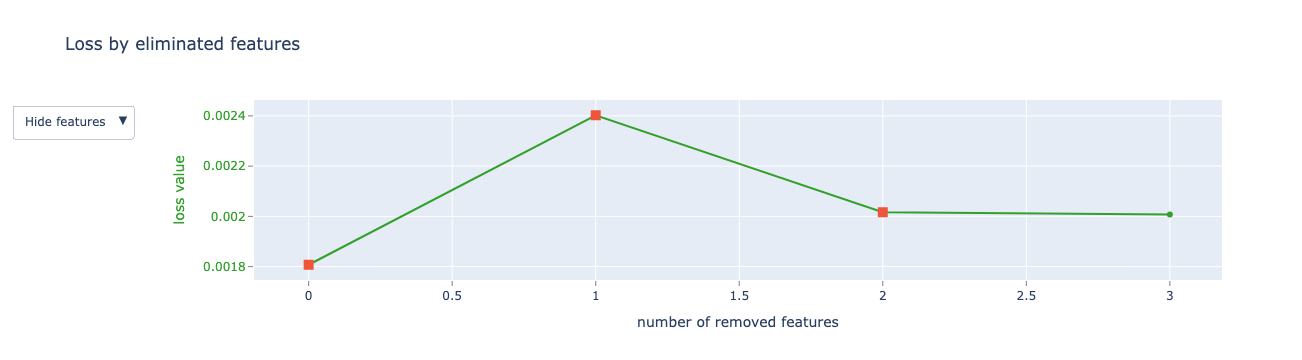

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041815
Step #1 out of 3

bestTest = 0.00189177488
bestIteration = 999

Feature #2 eliminated
Step #2 out of 3

bestTest = 0.002095340049
bestIteration = 290

Shrink model to first 291 iterations.
Feature #0 eliminated
Step #3 out of 3

bestTest = 0.002158850917
bestIteration = 293

Shrink model to first 294 iterations.
Feature #10 eliminated


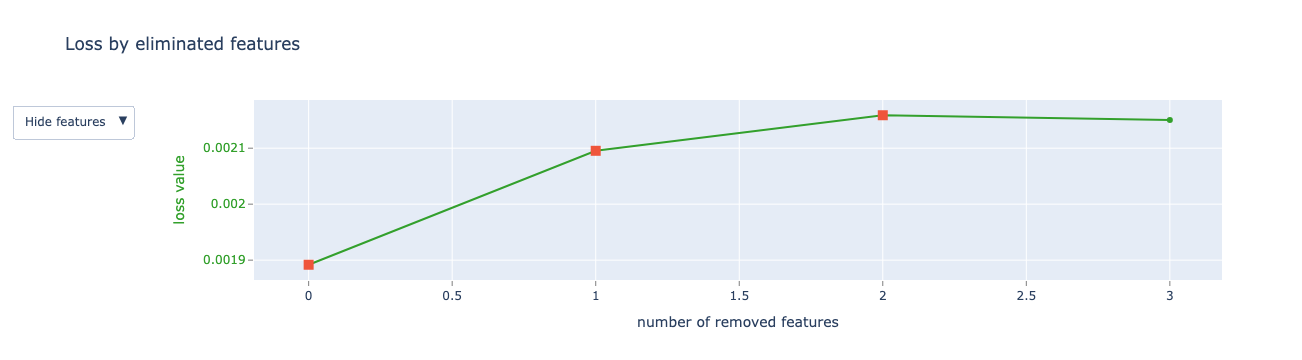

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041819
Step #1 out of 3

bestTest = 0.00254212863
bestIteration = 999

Feature #19 eliminated
Step #2 out of 3

bestTest = 0.002562247926
bestIteration = 999

Feature #4 eliminated
Step #3 out of 3

bestTest = 0.002167977562
bestIteration = 698

Shrink model to first 699 iterations.
Feature #12 eliminated


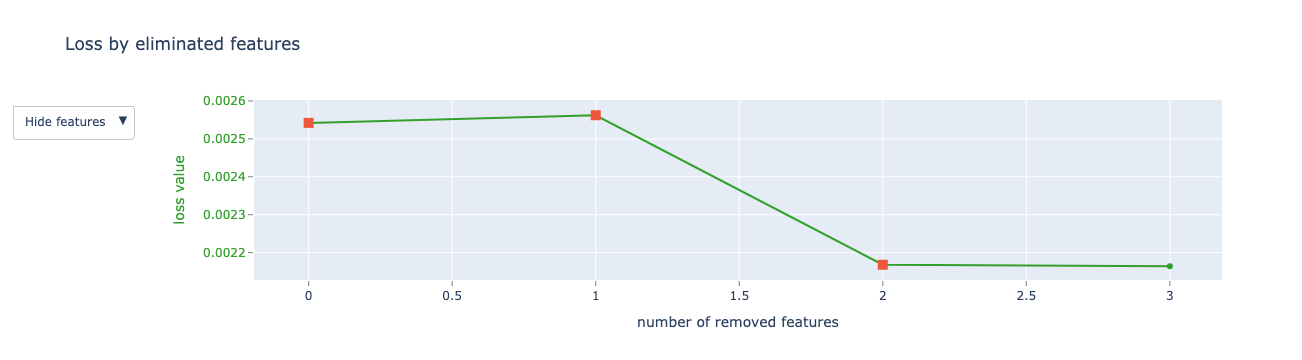

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041819
Step #1 out of 3

bestTest = 0.007214357606
bestIteration = 270

Shrink model to first 271 iterations.
Feature #16 eliminated
Step #2 out of 3

bestTest = 0.007097362767
bestIteration = 203

Shrink model to first 204 iterations.
Feature #7 eliminated
Step #3 out of 3

bestTest = 0.007292762115
bestIteration = 261

Shrink model to first 262 iterations.
Feature #4 eliminated


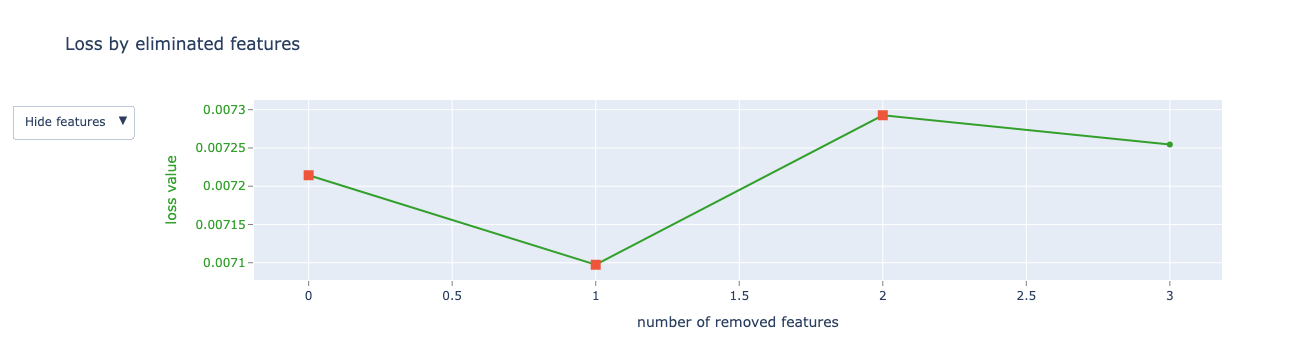

The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041819
Step #1 out of 3

bestTest = 0.001834726429
bestIteration = 433

Shrink model to first 434 iterations.
Feature #21 eliminated
Step #2 out of 3

bestTest = 0.001768533423
bestIteration = 603

Shrink model to first 604 iterations.
Feature #0 eliminated
Step #3 out of 3

bestTest = 0.001628447676
bestIteration = 999

Feature #15 eliminated


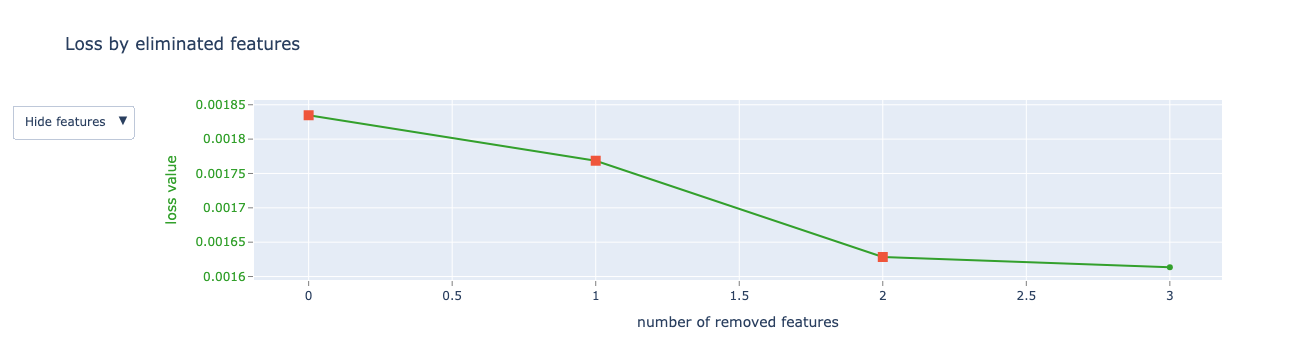

In [13]:
if CFG.FEATURE_ELIMINATION:
    selected_features = select_features_with_cv(df)
    feat_cols = selected_features.copy()

else:
    feat_cols = list(df.columns.difference(set(CFG.id_cols + [CFG.label])))

# Model training

In [14]:
class ModelManager:
    """
    Class for managing models, including training, exporting, and loading.

    Attributes:
    - model_name (str): Name of the model to be used (e.g., "CatBoost", "LGBM", "XGB").
    - model_directory (str): Directory to save/load models.
    - models (list): List of trained models.
    """

    def __init__(self, model_name, model_directory="models", models=[]):
        """
        Initialize the ModelManager object.

        Args:
        - model_name (str): Name of the model to be used.
        - model_directory (str): Directory to save/load models.
        - models (list): List of trained models.
        """

        self.model_name = model_name
        self.models = models
        self.model_directory = model_directory

    def train_models(self, data, target, params, cv_splits):
        """
        Train models using cross-validation.

        Args:
        - data (DataFrame): Input features.
        - target (Series): Target variable.
        - params (dict): Parameters for the model.
        - cv_splits (list of tuples): List of tuples containing train and validation indices.
        """

        for train_idx, val_idx in cv_splits:
            if self.model_name == "CatBoost":
                model = CatBoostClassifier(**params)
            elif self.model_name == "LGBM":
                model = LGBMClassifier(**params)
            elif self.model_name == "XGB":
                model = XGBClassifier(**params)

            model.fit(data.loc[train_idx], target.loc[train_idx])
            self.models.append(model)

    def get_models(self):
        """
        Get the list of trained models.

        Returns:
        - list: List of trained models.
        """
        return self.models

    def export_models(self):
        """
        Export trained models to files in the specified directory.
        """
        if not os.path.exists(self.model_directory):
            os.makedirs(self.model_directory)

        for idx, model in enumerate(self.models):
            filename = os.path.join(self.model_directory, f"Model_{idx}.pkl")
            with open(filename, "wb") as file:
                pickle.dump(model, file)

    def load_models(self):
        """
        Load models from files in the specified directory.
        """
        self.models = []
        for filename in os.listdir(self.model_directory):
            if "Model" in filename:
                with open(os.path.join(self.model_directory, filename), "rb") as file:
                    model = pickle.load(file)
                    self.models.append(model)

In [15]:
model_manager = ModelManager(best_model_name)

In [16]:
model_manager.train_models(df[feat_cols], df[CFG.label], params, cv_splits)
clear_output()

In [17]:
model_manager.export_models()

In [18]:
model_manager = ModelManager(best_model_name)

In [19]:
fold_thresholds = optimize_thresholds(
    df, models=model_manager.models, cv_splits=cv_splits, feat_cols=feat_cols
)

 20%|████████████████████████████▏                                                                                                                | 1/5 [00:00<00:01,  3.40it/s]

Threshold=0.100,  F1-Score=1.00000


 40%|████████████████████████████████████████████████████████▍                                                                                    | 2/5 [00:00<00:00,  3.41it/s]

Threshold=0.262,  F1-Score=0.99895


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3/5 [00:00<00:00,  3.44it/s]

Threshold=0.100,  F1-Score=1.00000


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4/5 [00:01<00:00,  3.46it/s]

Threshold=0.100,  F1-Score=0.99895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]

Threshold=0.148,  F1-Score=1.00000
CV SCORE: 0.9995811518324608


In [20]:
config = {
    "best_model_name": best_model_name,
    "feat_cols": feat_cols,
    "params": params,
    "label": CFG.label,
    "id_cols": CFG.id_cols,
    "FOLD_CNT": CFG.FOLD_CNT,
    "SEED": CFG.SEED,
    "DEVICE": CFG.DEVICE,
    "ITERATION": CFG.ITERATION,
    "TUNE": CFG.TUNE,
    "EVAL_METRIC": CFG.EVAL_METRIC,
    "N_TRIAL": CFG.N_TRIAL,
    "FEATURE_ELIMINATION": CFG.FEATURE_ELIMINATION,
    "USE_CIBIL": CFG.USE_CIBIL,
    "fold_thresholds": fold_thresholds,
}
with open("config.json", "w") as f:
    json.dump(config, f)

# Inference

In [21]:
class Inference:
    """
    Class for performing inference using trained models.

    Attributes:
    - config (dict): Configuration dictionary containing model information.
    """

    def __init__(self, config):
        """
        Initialize the Inference object.

        Args:
        - config (dict): Configuration dictionary containing model information.
        """

        self.config = config

    def train_inference(self, data):
        """
        Train the inference model.

        Args:
        - data (DataFrame): Training data.
        """
        pass

    def test_inference(self, data):
        """
        Perform inference on test data.

        Args:
        - data (dict): Dictionary containing the input data for inference.

        Returns:
        - int: Predicted label based on the majority vote of individual model predictions.
        """

        model_manager = ModelManager(self.config["best_model_name"])
        model_manager.load_models()
        data = pd.DataFrame([data])
        preprocessor = Preprocess(data, inference=True)

        data = preprocessor.execute()[feat_cols]

        probas = []
        preds = []
        for idx, model in enumerate(model_manager.models):
            proba = model.predict_proba(data)[:, 1][0]

            probas.append(proba)
            preds.append(int(proba > config["fold_thresholds"][idx]))
        return np.mean(probas), int(np.mean(preds))

In [22]:
inference = Inference(config)
data = {
    "loan_id": 1,
    "no_of_dependents": 2,
    "education": " Graduate",
    "self_employed": " No",
    "income_annum": 9600000,
    "loan_amount": 29900000,
    "loan_term": 12,
    "cibil_score": 778,
    "residential_assets_value": 2400000,
    "commercial_assets_value": 17600000,
    "luxury_assets_value": 22700000,
    "bank_asset_value": 8000000,
}
inference.test_inference(data)

(0.9995744233424869, 1)

# Model results

In [23]:
class ReportManager:
    def __init__(self, y_true, y_pred, y_prob=None):
        """
        Initialize the ReportManager with true labels, predicted labels, and predicted probabilities.

        Parameters:
        y_true (array-like): True binary labels.
        y_pred (array-like): Predicted binary labels.
        y_prob (array-like, optional): Predicted probabilities for the positive class.
        """
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_prob = y_prob

    def classification_report(self):
        """
        Print the classification report.

        The classification report provides the following metrics:
        - Precision: The ratio of true positive predictions to the total predicted positives. It indicates how many of the predicted positive cases are actually positive.
        - Recall (Sensitivity): The ratio of true positive predictions to the total actual positives. It measures how well the model identifies positive cases.
        - F1 Score: The harmonic mean of precision and recall, providing a single metric that balances the two.
        - Support: The number of actual occurrences of each class in the dataset.
        """
        from sklearn.metrics import classification_report

        print(classification_report(self.y_true, self.y_pred))

    def draw_confusion_matrix(self):
        """
        Draw the confusion matrix.

        The confusion matrix is a table that evaluates the performance of a classification model by showing the counts of:
        - True Positive (TP): Correctly predicted positive cases.
        - True Negative (TN): Correctly predicted negative cases.
        - False Positive (FP): Incorrectly predicted positive cases (Type I error).
        - False Negative (FN): Incorrectly predicted negative cases (Type II error).

        Insights:
        - High TP and TN values indicate good model performance.
        - High FP and FN values indicate potential areas for model improvement.
        """
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        import matplotlib.pyplot as plt

        cm = confusion_matrix(self.y_true, self.y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

    def draw_roc_curve(self):
        """
        Draw the ROC curve.

        The ROC (Receiver Operating Characteristic) curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The area under the ROC curve (AUC) measures the model's ability to distinguish between classes:
        - TPR (Recall): True positives / (True positives + False negatives).
        - FPR: False positives / (False positives + True negatives).
        - AUC: The higher the AUC, the better the model's performance.

        Insights:
        - A curve close to the top left corner indicates a good model.
        - An AUC closer to 1 indicates better discrimination ability.
        """
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt

        fpr, tpr, _ = roc_curve(self.y_true, self.y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label="ROC curve (area = %0.2f)" % roc_auc,
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic")
        plt.legend(loc="lower right")
        plt.show()

    def draw_precision_recall_curve(self):
        """
        Draw the Precision-Recall curve.

        The precision-recall curve plots precision against recall for different threshold values. This is especially useful when the classes are imbalanced:
        - Precision: The ratio of true positive predictions to the total predicted positives.
        - Recall: The ratio of true positive predictions to the total actual positives.

        Insights:
        - Helps in understanding the trade-off between precision and recall for different thresholds.
        - Useful for identifying the optimal threshold for classification.
        """
        from sklearn.metrics import precision_recall_curve, average_precision_score
        import matplotlib.pyplot as plt

        precision, recall, _ = precision_recall_curve(self.y_true, self.y_prob)
        average_precision = average_precision_score(self.y_true, self.y_prob)

        plt.figure()
        plt.step(recall, precision, where="post")

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall curve: AP={0:0.2f}".format(average_precision))
        plt.show()

    def draw_lift_chart(self):
        """
        Draw the Lift chart.

        The lift chart visualizes the lift of the model compared to random selection:
        - Lift: The ratio of the model's precision to the precision of a random classifier.

        Insights:
        - A higher lift indicates better performance of the model compared to random guessing.
        - Useful for understanding how well the model can identify positive cases compared to random selection.
        """
        import matplotlib.pyplot as plt
        import numpy as np

        data = sorted(zip(self.y_prob, self.y_true), reverse=True, key=lambda x: x[0])
        gains = np.cumsum([x[1] for x in data]) / np.sum(self.y_true)
        random_gains = np.linspace(0, 1, len(gains))

        plt.figure()
        plt.plot(gains, label="Model")
        plt.plot(random_gains, linestyle="--", label="Random")
        plt.xlabel("Number of Samples")
        plt.ylabel("Cumulative Gains")
        plt.title("Lift Chart")
        plt.legend()
        plt.show()

    def draw_gains_chart(self):
        """
        Draw the Gains chart.

        The gains chart shows the cumulative gains over the population:
        - Gains: The cumulative number of positive cases identified by the model compared to random selection.

        Insights:
        - Helps in understanding the cumulative performance of the model over the dataset.
        - Useful for identifying how well the model can capture positive cases compared to random guessing.
        """
        import matplotlib.pyplot as plt
        import numpy as np

        data = sorted(zip(self.y_prob, self.y_true), reverse=True, key=lambda x: x[0])
        gains = np.cumsum([x[1] for x in data]) / np.sum(self.y_true)
        random_gains = np.linspace(0, 1, len(gains))

        plt.figure()
        plt.plot(np.linspace(0, 1, len(gains)), gains, label="Model")
        plt.plot(
            np.linspace(0, 1, len(gains)), random_gains, linestyle="--", label="Random"
        )
        plt.xlabel("Percentage of Samples")
        plt.ylabel("Cumulative Gains")
        plt.title("Gains Chart")
        plt.legend()
        plt.show()

    def execute(self):
        print("#" * 50)
        print("#" * 10, "CLASSIFICATION REPORT")
        self.classification_report()

        print("#" * 50)
        print("#" * 10, "CONFUSION MATRIX")
        self.draw_confusion_matrix()

        print("#" * 50)
        print("#" * 10, "ROC CURVE")
        self.draw_roc_curve()

        print("#" * 50)
        print("#" * 10, "PRECISION RECALL CURVE")
        self.draw_precision_recall_curve()

        print("#" * 50)
        print("#" * 10, "LIFT CHART")
        self.draw_lift_chart()

        print("#" * 50)
        print("#" * 10, "GAINS CHART")
        self.draw_gains_chart()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.79it/s]

##################################################
########## CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1452
           1       1.00      1.00      1.00      2390

    accuracy                           1.00      3842
   macro avg       1.00      1.00      1.00      3842
weighted avg       1.00      1.00      1.00      3842

##################################################
########## CONFUSION MATRIX


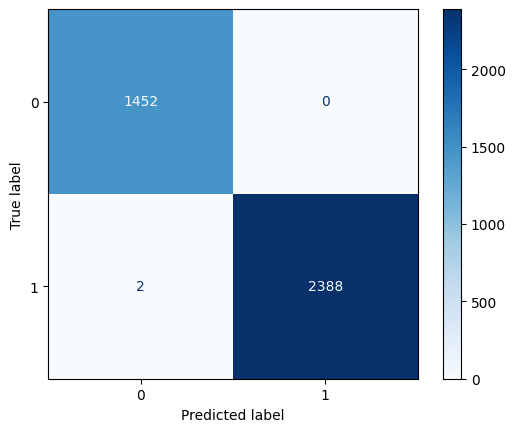

##################################################
########## ROC CURVE


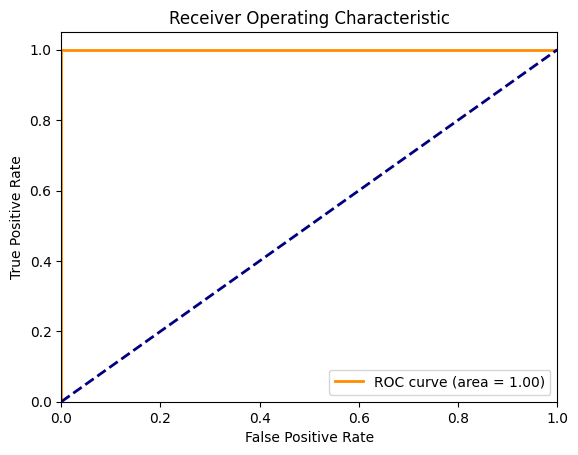

##################################################
########## PRECISION RECALL CURVE


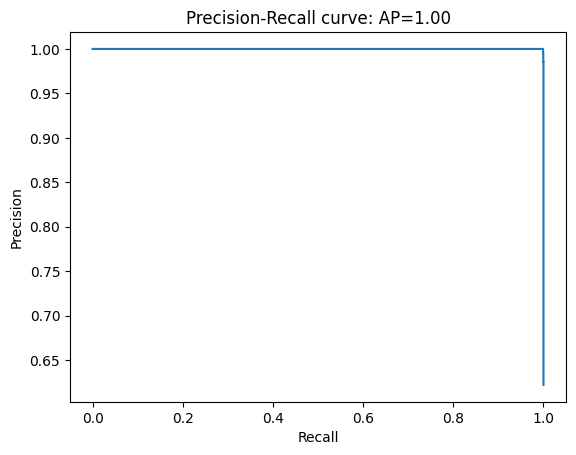

##################################################
########## LIFT CHART


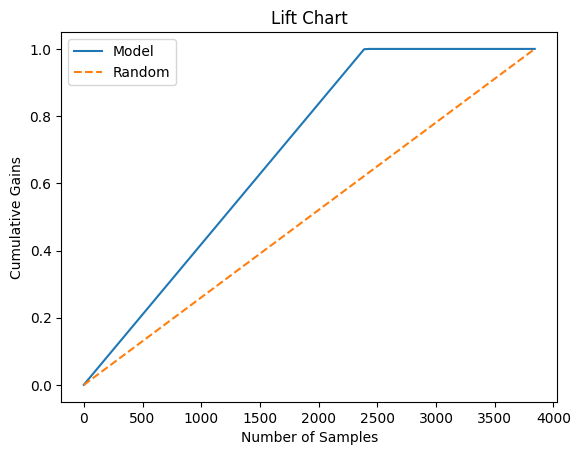

##################################################
########## GAINS CHART


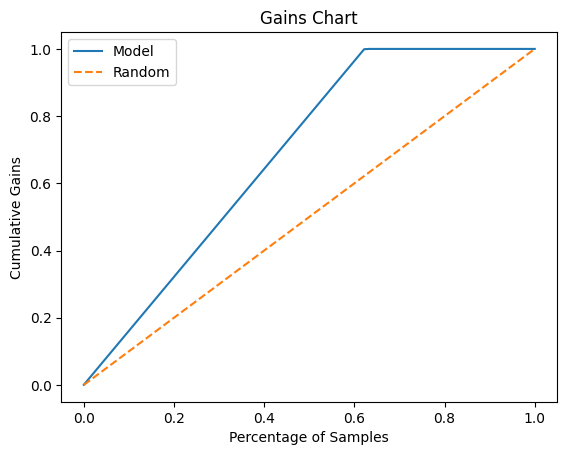

In [24]:
# OOF report
df["oof_preds"] = np.nan
df["oof_preds_proba"] = np.nan

for idx, (split_train, split_val) in enumerate(tqdm(cv_splits)):
    df["oof_preds"].loc[split_val] = pd.Series(
        (
            model_manager.models[idx].predict_proba(df.loc[split_val])[:, 1]
            > fold_thresholds[idx]
        ).astype(int)
    ).values

    df["oof_preds_proba"].loc[split_val] = pd.Series(
        (model_manager.models[idx].predict_proba(df.loc[split_val])[:, 1])
    ).values

report_manager = ReportManager(
    df["loan_status"], df["oof_preds"], df["oof_preds_proba"]
)
report_manager.execute()

In [25]:
# Test report
probas = []
preds = []
inference = Inference(config)
for index, row in test.iterrows():
    data = dict(row)
    proba, pred = inference.test_inference(data)
    probas.append(proba)
    preds.append(pred)
test["predict_proba"] = probas
test["predict"] = preds

In [26]:
test[" loan_status"] = test[" loan_status"].replace({" Approved": 1, " Rejected": 0})

##################################################
########## CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       1.00      0.99      1.00       266

    accuracy                           1.00       427
   macro avg       0.99      1.00      1.00       427
weighted avg       1.00      1.00      1.00       427

##################################################
########## CONFUSION MATRIX


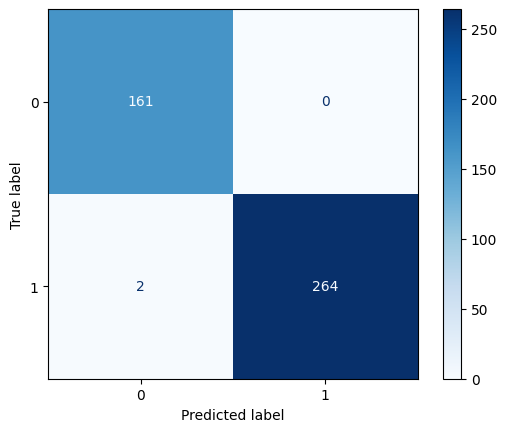

##################################################
########## ROC CURVE


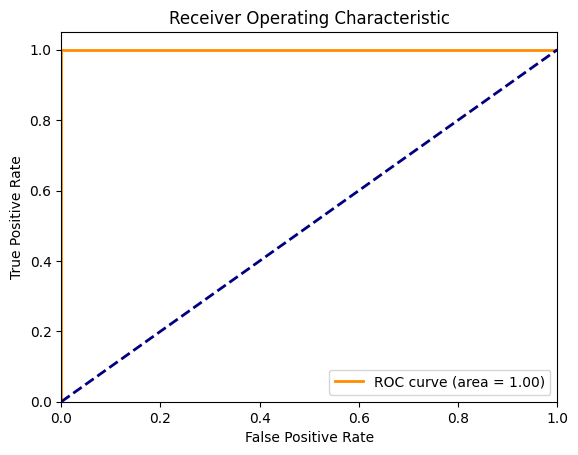

##################################################
########## PRECISION RECALL CURVE


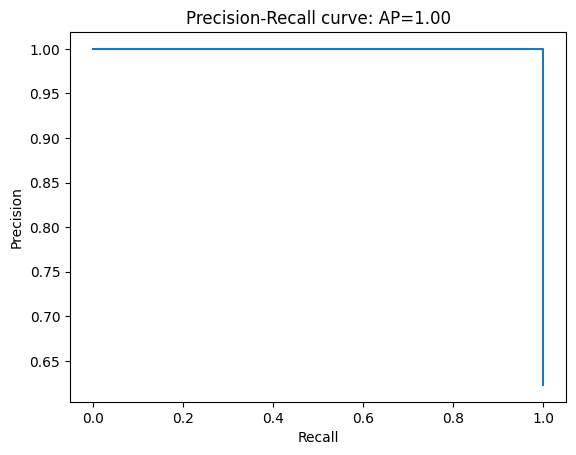

##################################################
########## LIFT CHART


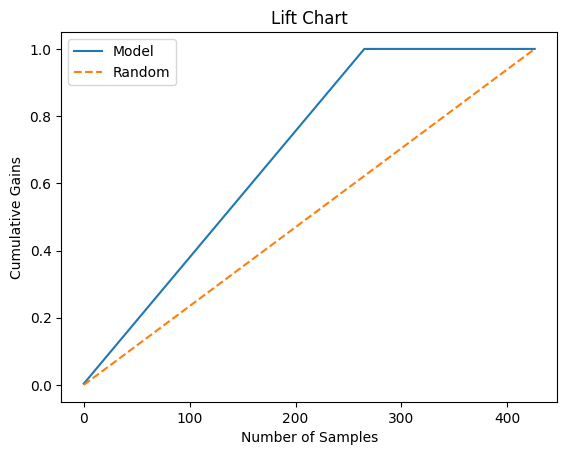

##################################################
########## GAINS CHART


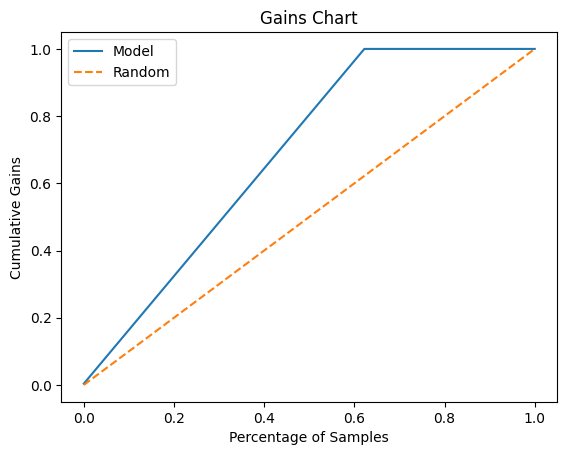

In [27]:
report_manager = ReportManager(
    test[" loan_status"], test["predict"], test["predict_proba"]
)
report_manager.execute()

In [28]:
class ModelExplainer:
    def __init__(self, models, cv_splits, data):
        """
        Initialize the ModelExplainer with models, cross-validation splits, and data.

        Parameters:
        models (list): List of trained models (LightGBM, CatBoost, XGBoost).
        cv_splits (list of tuples): List of (train_index, validation_index) tuples.
        data (tuple): Tuple containing (X, y) where X is the feature set and y is the target variable.
        """
        self.models = models
        self.cv_splits = cv_splits
        self.X, self.y = data

    def plot_feature_importance(self):
        """
        Plot feature importance averaged over cross-validation splits for each model.

        This method calculates the feature importance for each fold and averages them
        to provide a more robust estimate of feature importance.
        """
        import numpy as np
        import matplotlib.pyplot as plt

        feature_importances = []

        for model in self.models:
            if hasattr(model, "feature_importances_"):
                feature_importances.append(model.feature_importances_)
            elif hasattr(model, "get_feature_importance"):
                feature_importances.append(model.get_feature_importance())

        mean_importance = np.mean(feature_importances, axis=0)
        std_importance = np.std(feature_importances, axis=0)

        indices = np.argsort(mean_importance)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(
            range(self.X.shape[1]),
            mean_importance[indices],
            color="b",
            yerr=std_importance[indices],
            align="center",
        )
        plt.xticks(
            range(self.X.shape[1]), np.array(self.X.columns)[indices], rotation=90
        )
        plt.xlim([-1, self.X.shape[1]])
        plt.tight_layout()
        plt.show()

    def plot_decision_tree(self):
        # todo fix
        """
        Plot decision trees for models that support it (e.g., LightGBM, XGBoost, CatBoost).

        This method visualizes the first tree in the ensemble for each model.
        """
        import matplotlib.pyplot as plt
        from lightgbm import plot_tree as lgb_plot_tree
        from xgboost import plot_tree as xgb_plot_tree
        from catboost import CatBoostClassifier, Pool
        from IPython.display import display

        i = 0
        model = self.models[i]
        plt.figure(figsize=(20, 10))
        if isinstance(model, CatBoostClassifier):
            # Extract tree structure using CatBoost visualizer
            model.plot_tree(
                tree_idx=0,
                pool=Pool(self.X, self.y),
            )
        elif hasattr(model, "booster"):
            if hasattr(model, "get_booster"):
                model = model.get_booster()
            if "xgboost" in str(type(model)):
                xgb_plot_tree(model, num_trees=0)
            elif "lightgbm" in str(type(model)):
                lgb_plot_tree(
                    model, tree_index=0, figsize=(20, 10), show_info=["split_gain"]
                )

        plt.title(f"Decision Tree for Model {i+1}")
        plt.show()

    def plot_shap_summary(self, plot_type="bar"):
        """
        Plot SHAP summary values for each model.

        This method uses SHAP library to explain the output of the models.

        Parameters:
        plot_type (str): Type of summary plot to display, either "bar" or "beeswarm".
        """
        import shap

        model = self.models[0]
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(self.X)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        if plot_type == "bar":
            shap.summary_plot(shap_values, self.X, plot_type="bar")
        else:
            shap.summary_plot(shap_values, self.X)

    def plot_shap_dependence(self, feature):
        """
        Plot SHAP dependence plot for a specific feature.

        This method uses SHAP library to explain the dependence of a feature on SHAP values.

        Parameters:
        feature (str): The feature to plot.
        """
        import shap

        model = self.models[0]

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(self.X)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        shap.dependence_plot(feature, shap_values, self.X)

    def plot_shap_force(self, sample_index=0):
        """
        Plot SHAP force plot for the entire dataset.

        This method uses SHAP library to explain the output of the models.
        """
        import shap
        import matplotlib.pyplot as plt

        model = self.models[0]
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(self.X)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        # Plot force plot for a specific sample
        shap.force_plot(
            explainer.expected_value,
            shap_values[sample_index],
            self.X.iloc[sample_index],
            matplotlib=True,
        )
        plt.show()

In [29]:
explainer = ModelExplainer(
    model_manager.models, cv_splits, (df[feat_cols], df["loan_status"])
)

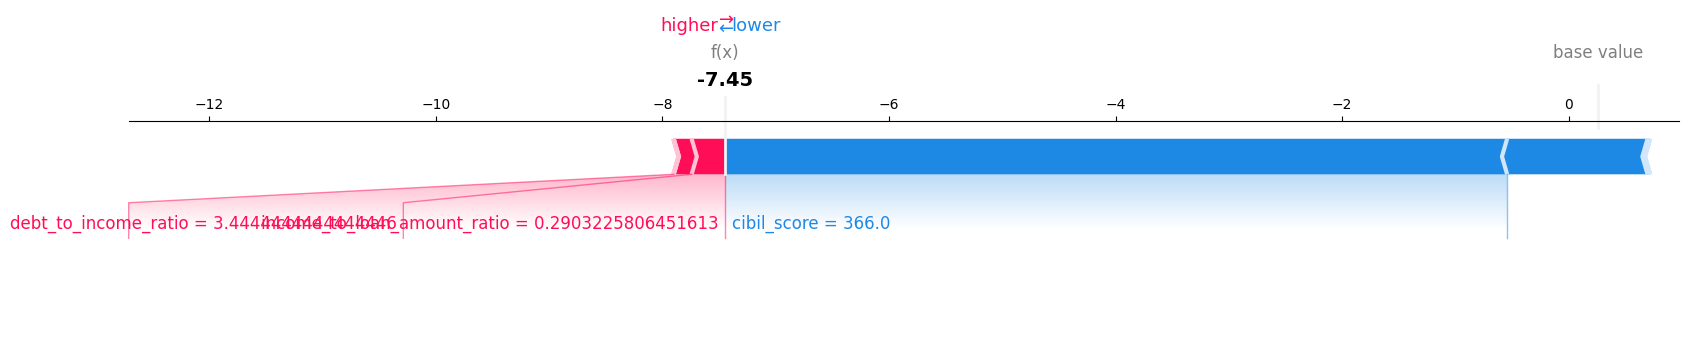

In [30]:
explainer.plot_shap_force()

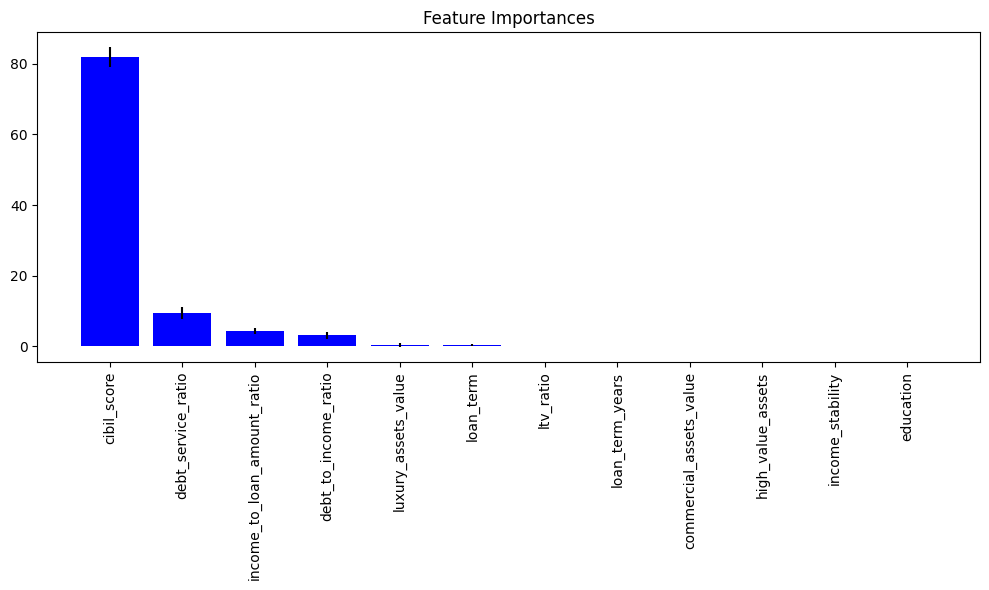

In [31]:
explainer.plot_feature_importance()

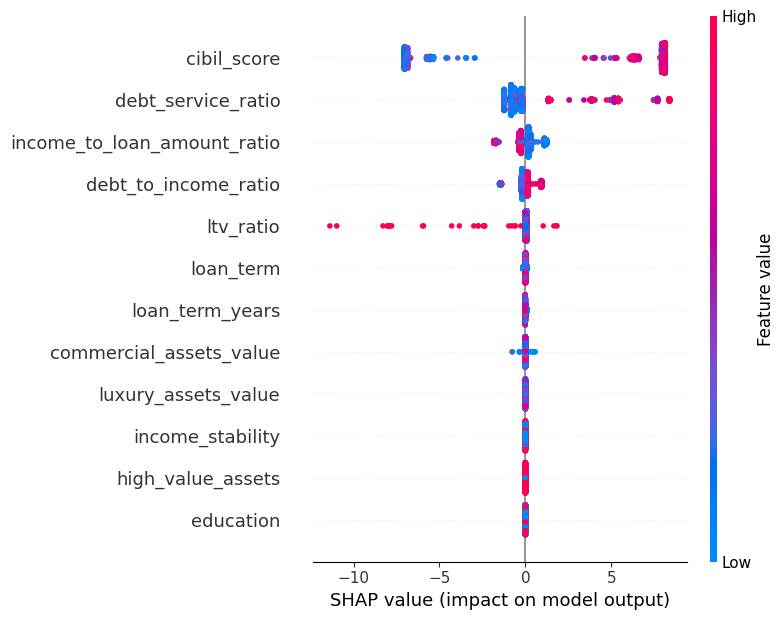

In [32]:
explainer.plot_shap_summary(plot_type="beeswarm")

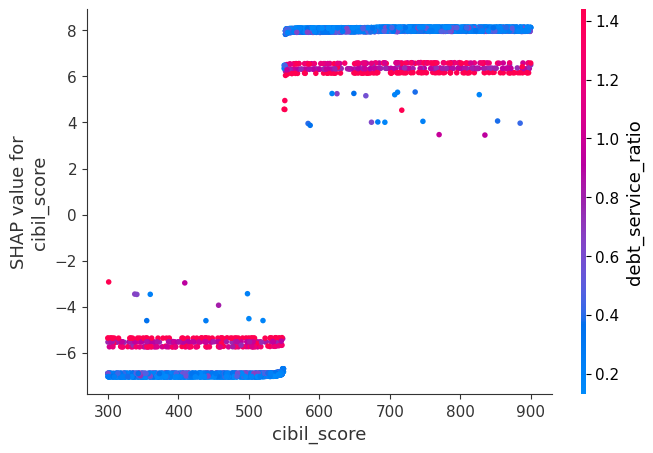

In [33]:
explainer.plot_shap_dependence("cibil_score")